In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas
import pointprocesses as ppr

In [3]:
import torch

# Données synthétiques

In [4]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [5]:
import itertools
mu = 1.0
tmax = 5.0
alpha = 0.25
beta  = 2.0

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 6.667


In [6]:
n_traj = 5000
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

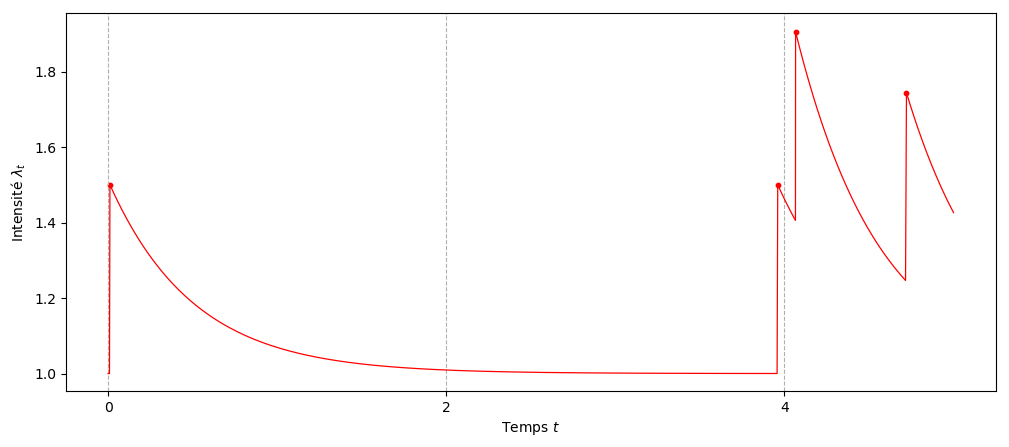

In [7]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [8]:
input_size = max(s.shape[0] for s in sample_trajectories)
print("Input size max. traj. length: \t%d" % input_size)
print("Number of samples: \t\t%d" % len(sample_trajectories))
length_array = [s.shape[0] for s in sample_trajectories]
data_array = np.stack([np.pad(s[:,0], ((0, input_size - s.shape[0])), 'constant') for s in sample_trajectories])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

Input size max. traj. length: 	22
Number of samples: 		5000


In [9]:
data_tensor.shape

torch.Size([5000, 22])

The first dimension is for time, the second for the sample.

## Neural net

In [10]:
import torch
import torch.nn as nn
from torch import optim

In [11]:
device = torch.device("cpu")
print(device)

cpu


In [12]:
torch.manual_seed(1)

$$
    \lambda_k(t) = f_k(\mathbf w_k^\intercal\mathbf h(t))
$$

$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i]
$$

In [23]:
from model import NeuralCTLSTM

In [24]:
import tqdm

In [25]:
# We use mini-batches to train on our data
BATCH_SIZE = 40
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

Batch size: 40
Training sample size: 5000
Splitting into batches of 40
No. of batches: 125


In [26]:
nhlstm = NeuralCTLSTM(10)
optimizer = optim.SGD(nhlstm.parameters(), lr=0.0005)

In [27]:
nhlstm.zero_grad()
batch_range = tqdm.trange(num_of_batches)
loss_hist = []
for i in batch_range:
    batch_range.set_description("Batch %d" % i)
    # Train on each batch
    event_times = split_into_batches[i]
    inter_t = event_times[:,:-1] - event_times[:,1:] # transform into inter-arrival times
    batch_size = inter_t.size(0)
    output_hist = []
    hidden_hist = []
    cell_hist = []
    cell_target_hist = []
    decay_hist = []
    hidden, cti, cbar = nhlstm.init_hidden(batch_size)
    for j in range(input_size - 1):
        # print("Time t=%d\t|\t" % j, end=' ')
        # Loop over times
        # Feed the RNN each batch of interarrival times
        output, hidden, cti, cell_t, cbar, decay_t = nhlstm(inter_t[:,j], hidden, cti, cbar)
        output_hist.append(output)
        hidden_hist.append(hidden)
        cell_hist.append(cti)
        cell_target_hist.append(cbar)
        decay_hist.append(decay_t)
    output_hist = torch.stack(output_hist, dim=1)
    hidden_hist = torch.stack(hidden_hist, dim=1)
    cell_hist = torch.stack(cell_hist, dim=1)
    cell_target_hist = torch.stack(cell_target_hist, dim=1)
    decay_hist = torch.stack(decay_hist, dim=1)
    # print('output_hist shape %s' % str(output_hist.shape))

    loss = nhlstm.likelihood(event_times, cell_hist, cell_target_hist, output_hist, decay_hist, tmax)
    loss.backward()  # compute the gradients
    loss_val = loss.item()
    batch_range.set_postfix(loss=loss_val)
    loss_hist.append(loss_val) # record the loss value
    optimizer.step() # do a step of the SGD algorithm




  0%|          | 0/125 [00:00<?, ?it/s]

Batch 0:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 0:   0%|          | 0/125 [00:00<?, ?it/s, loss=-6.19]

Batch 1:   0%|          | 0/125 [00:00<?, ?it/s, loss=-6.19]

Batch 1:   0%|          | 0/125 [00:00<?, ?it/s, loss=-5.53]

Batch 1:   2%|▏         | 2/125 [00:00<00:09, 12.77it/s, loss=-5.53]

Batch 2:   2%|▏         | 2/125 [00:00<00:09, 12.77it/s, loss=-5.53]

Batch 2:   2%|▏         | 2/125 [00:00<00:09, 12.77it/s, loss=-6.75]

Batch 3:   2%|▏         | 2/125 [00:00<00:09, 12.77it/s, loss=-6.75]

Batch 3:   2%|▏         | 2/125 [00:00<00:09, 12.77it/s, loss=-5.25]

Batch 3:   3%|▎         | 4/125 [00:00<00:08, 13.94it/s, loss=-5.25]

Batch 4:   3%|▎         | 4/125 [00:00<00:08, 13.94it/s, loss=-5.25]

Batch 4:   3%|▎         | 4/125 [00:00<00:08, 13.94it/s, loss=-6.48]

Batch 5:   3%|▎         | 4/125 [00:00<00:08, 13.94it/s, loss=-6.48]

Batch 5:   3%|▎         | 4/125 [00:00<00:08, 13.94it/s, loss=-13.6]

Batch 6:   3%|▎      

Text(0.5, 1.0, 'Loss = negative log-likelihood')

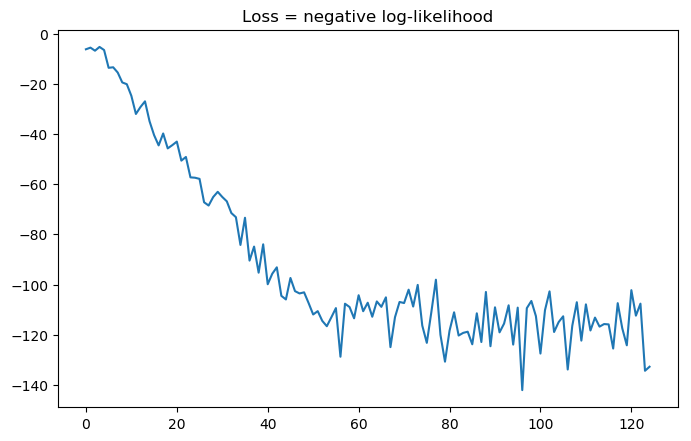

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)

ax.plot(range(num_of_batches), loss_hist)
ax.set_title("Loss = negative log-likelihood")